In [5]:
import sys

sys.path.append("../../src")

In [6]:
import numpy as np
import gaussian_overlap
import importlib
import h5py
import pandas as pd
from scipy.linalg import eigh

from scipy.optimize import minimize

importlib.reload(gaussian_overlap)
from gaussian_overlap import *
from sto_ng_overlap import *

In [7]:
df = pd.read_csv("../make_base/sto_3g.csv")
df

,exps_1,coefs_1s,exps_2,coefs_2s,coefs_2p
0,0.109987,0.445576,0.074759,0.694673,0.387976
1,0.407154,0.535362,0.229124,0.405616,0.608867
2,2.246014,0.153482,0.979606,-0.100240,0.158557


In [8]:
zetaH = 1.24
r = 1.0
param1 = {
    "center": np.array([0, 0, 0]),
    "lmn": (0, 0, 0),
    "exps": np.array(df["exps_1"]) * zetaH**2,
    "coefs": np.array(df["coefs_1s"]),
}
param2 = {
    "center": np.array([r, 0, 0]),
    "lmn": (0, 0, 0),
    "exps": np.array(df["exps_1"]) * zetaH**2,
    "coefs": np.array(df["coefs_1s"]),
}
a = BasisFunction(**param1)
b = BasisFunction(**param2)

basis = [a, b]
get_ERImat(basis)

array([[[[0.77477928, 0.56890626],
         [0.56890626, 0.65026855]],

        [[0.56890626, 0.45589   ],
         [0.45589   , 0.56890626]]],


       [[[0.56890626, 0.45589   ],
         [0.45589   , 0.56890626]],

        [[0.65026855, 0.56890626],
         [0.56890626, 0.77477928]]]])

In [9]:
def get_energy(r, c_up_init, c_dn_init):
    zetaH = 1.24
    param1 = {
        "center": np.array([0, 0, 0]),
        "lmn": (0, 0, 0),
        "exps": np.array(df["exps_1"]) * zetaH**2,
        "coefs": np.array(df["coefs_1s"]),
    }
    param2 = {
        "center": np.array([r, 0, 0]),
        "lmn": (0, 0, 0),
        "exps": np.array(df["exps_1"]) * zetaH**2,
        "coefs": np.array(df["coefs_1s"]),
    }
    basea = BasisFunction(**param1)
    baseb = BasisFunction(**param2)
    basis = [basea, baseb]
    Tmat = get_Tmat(basis)
    Vmat = -get_Vmat(basis, [0, 0, 0]) - get_Vmat(basis, [r, 0, 0])
    ERImat = get_ERImat(basis)
    Smat = get_Smat(basis)
    hmat = Tmat + Vmat
    new_energy = 0
    c_up = c_up_init
    c_dn = c_dn_init
    iteration = 10000
    for i in range(iteration):
        J_mat_up = np.einsum("ijkl, k, l -> ij", ERImat, c_dn, c_dn)
        fock_mat_up = hmat + J_mat_up
        J_mat_dn = np.einsum("ijkl, k, l -> ij", ERImat, c_up, c_up)
        fock_mat_dn = hmat + J_mat_dn

        valup, vecup = eigh(fock_mat_up, Smat)
        valdn, vecdn = eigh(fock_mat_dn, Smat)

        if iteration < 1000:
            c_up = 0.9 * c_up + 0.1 * vecup[:, 0]
            c_dn = 0.9 * c_dn + 0.1 * vecdn[:, 0]
        else:
            c_up = 0.99 * c_up + 0.01 * vecup[:, 0]
            c_dn = 0.99 * c_dn + 0.01 * vecdn[:, 0]

        c_up = c_up / (c_up @ Smat @ c_up)
        c_dn = c_dn / (c_dn @ Smat @ c_dn)

        old_energy = new_energy
        new_energy = (
            valup[0]
            + valdn[0]
            - vecup[:, 0] @ J_mat_up @ vecup[:, 0] * 0.5
            - vecdn[:, 0] @ J_mat_dn @ vecdn[:, 0] * 0.5
        )
        if np.abs(new_energy - old_energy) < 1e-6:
            break
        if i == iteration - 1:
            print("Not converged")

    return new_energy + 1 / r, c_up, c_dn

In [10]:
rs = np.linspace(0.5, 6, 100)
c_up = np.array([1, 0])
c_dn = np.array([0, 1])
es = []
for i, r in enumerate(reversed(rs)):
    print(c_up, c_dn)
    e, c_up, c_dn = get_energy(r, c_up, c_dn)
    es.insert(0, e)

[1 0] [0 1]
[0.00699432 0.99988707] [-0.99988629 -0.00699018]
[0.00725151 0.99987865] [-0.99987839 -0.00725012]
[0.00769512 0.99986252] [-0.99986247 -0.00769487]
[0.00814031 0.99984506] [-0.99984505 -0.00814027]
[0.00860313 0.99982568] [-0.99982568 -0.00860312]
[0.00908766 0.99980408] [-0.99980408 -0.00908766]
[0.00959704 0.99977995] [-0.99977995 -0.00959704]


[0.0101298  0.99975313] [-0.99975313 -0.0101298 ]
[0.01068842 0.99972326] [-0.99972326 -0.01068842]
[0.01127556 0.99968995] [-0.99968995 -0.01127556]
[0.01189038 0.99965296] [-0.99965296 -0.01189038]
[0.01253543 0.99961181] [-0.99961181 -0.01253543]
[0.01321335 0.99956601] [-0.99956601 -0.01321335]
[0.01392399 0.99951516] [-0.99951516 -0.01392399]
[0.0146709  0.99945862] [-0.99945862 -0.0146709 ]
[0.01545447 0.99939589] [-0.99939589 -0.01545447]
[0.01627834 0.99932617] [-0.99932617 -0.01627834]
[0.0171434  0.99924885] [-0.99924885 -0.0171434 ]
[0.01805348 0.99916298] [-0.99916298 -0.01805348]
[0.01901    0.99906775] [-0.99906775 -0.01901   ]
[0.02001706 0.99896204] [-0.99896204 -0.02001706]
[0.02107668 0.99884483] [-0.99884483 -0.02107668]
[0.02219332 0.99871474] [-0.99871474 -0.02219332]
[0.02336968 0.9985705 ] [-0.9985705  -0.02336968]
[0.0246107  0.99841041] [-0.99841041 -0.0246107 ]
[0.0259198  0.99823288] [-0.99823288 -0.0259198 ]
[0.02730253 0.99803583] [-0.99803583 -0.02730253]


Text(0, 0.5, 'E(H2) - 2E(H) (a. u.)')

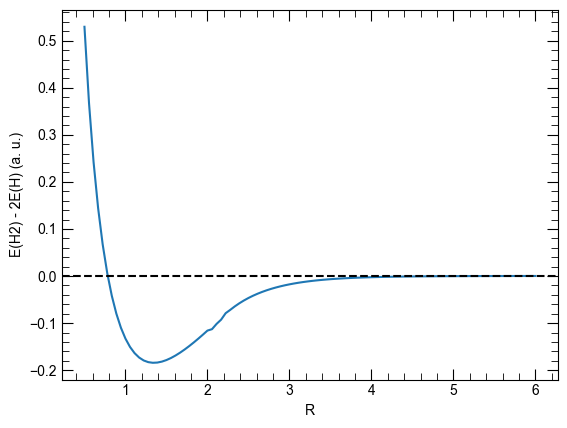

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(rs, np.array(es) + 2 * 0.4666)
ax.axhline(0, color="black", linestyle="--")
ax.set_xlabel("R")
ax.set_ylabel("E(H2) - 2E(H) (a. u.)")